# Validação do modelo de machine learning para aplicação nos Guardioes da Saude para match com síndrome gripal. 

Dados obtidos dos dados abertos do e-sus no [site](https://opendatasus.saude.gov.br/gl/dataset/casos-nacionais). Nesse arquivo foram treinados Um modelo de regressão linear múltipla e uma classificador do xgboost. 


In [1]:
# Bibliotecas a serem importadas.
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import scikitplot as skplt
from imblearn.over_sampling import RandomOverSampler
import glob, os
from tqdm.notebook import tqdm_notebook
import time

tqdm_notebook.pandas()

### Leitura dos arquivos .csv

Aqui é onde é lido so dados em .csv na pasta /data. Esses dados ja estão pré-tratados. Há também uma função que realiza esse pré-tratamento removendo algumas colunas que não serão usadas e para economizar processamento e memória foi utilizada essa abordagem.

In [2]:
# Diminuindo tamanhos dos arquivos

baseDados = pd.Series()
def read_from_data_covid():
    all_files = glob.glob('./data-covid' + '/*.csv')

    li = [] 

    for file in tqdm_notebook(all_files):
        df = pd.read_csv(file, delimiter=';', encoding='latin-1')
        df = df.drop([
        'dataNotificacao',
        'dataTeste',
        'tipoTeste',
        'dataEncerramento',
        'evolucaoCaso',
        'classificacaoFinal',
        'estadoNotificacaoIBGE',
        'municipioIBGE',
        'cbo',
        'municipioNotificacaoIBGE',
        'estadoIBGE',
        'estadoTeste',
        'paisOrigem',
        'origem',
        'estadoNotificacao',
        'municipioNotificacao',
        'excluido', 
        'validado',
        'dataInicioSintomas',
        'profissionalSaude',
        'dataNascimento',
        'estado',
        'municipio'
        ], axis=1)
        df.to_csv(file, sep=';', encoding='utf-8')
        print(file)
    

all_files = glob.glob('./data' + '/*.csv')

for file in tqdm_notebook(all_files):
    df = pd.read_csv(file, delimiter=';', encoding='latin-1')
    baseDados = pd.concat([baseDados, df], ignore_index=True)

baseDados.head()

/tmp/ipykernel_31102/3984688647.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  baseDados = pd.Series()


  0%|          | 0/20 [00:00<?, ?it/s]

,0,Unnamed: 0,condicoes,idade,resultadoTeste,sexo,sintomas,Ã¿id
0,NaN,0.0,NaN,73.0,NaN,Feminino,Outros,N1wIAd08lL
1,NaN,1.0,NaN,36.0,Positivo,Masculino,"Febre, Dor de Garganta, Outros",QW8RQcjzLD
2,NaN,2.0,NaN,34.0,Negativo,Feminino,Tosse,8FNnth9ADm
3,NaN,3.0,NaN,20.0,Positivo,Masculino,"Tosse, Febre, Dor de Garganta, Outros",EzdQ9dZQD7
4,NaN,4.0,NaN,32.0,Negativo,Feminino,Outros,b3ZXuX9rRs


### Removendo linhas em que a string na coluna 'resultadoTeste' é inválido. 


Como esse campo é importante (conjunto de saída do modelo), então foi filtrado apenas os dados em que essa coluna possui um valor válido. 

### Criando colunas para sintomas. 

Após essa remoção foi elaborado uma maneira de tranformar a lista de sintomas de cada dado em várias colunas que tem como conjunto de valores {1, 0}. Assim o modelo conseguirá entender essas variáveis e permitirá o treinamento. Há varios sintomas e por isso foi testado algumas listas de sintomas para serem usados. Para cada sintoma foi definido uma string de busca para conseguir detectar a ocorrência do sintoma no dado. 

In [3]:
# Removendo linhas em que o resultado é invalido.

mask = (baseDados['resultadoTeste'] != 'Negativo') & (baseDados['resultadoTeste'] != 'Positivo')
baseDados = baseDados.loc[~mask]


baseDados.columns

Index([               0,     'Unnamed: 0',      'condicoes',          'idade',
       'resultadoTeste',           'sexo',       'sintomas',           'Ã¿id'],
      dtype='object')

In [4]:
# Pegando a lista de sintomas.
baseDados = baseDados.drop(['Ã¿id', 'Unnamed: 0', 0], axis=1)
# sintomas = set()
# for tmp in tqdm_notebook(baseDados['sintomas']):
#     for tmp2 in str(tmp).split(','):
#         sintomas.add(tmp2.lower().replace(' ','').replace('outros', ''))

# to_remove = ['', 'assintomático', 'nan', ':pacienteassintomático']
# sintomas.difference_update(to_remove)
# sintomas = list(sintomas)
# print(sintomas)

  0%|          | 0/11047893 [00:00<?, ?it/s]

['febredordegarganta', 'epistaxe', 'faltadepaladareolfato', 'pigarro', 'distãºrbiosgustativos', ':pacienteassintomã¡tico', 'perdaolfatoepaladar', 'dordegarganta', 'perdadocheiro', 'dispneia', 'inapetãªncia', 'hiposmiaeanosmia.desconfortoabdominal.ediarreia', 'faltadepaladar', 'irritaã§ã£onoolhos', 'assintomã¡tico', 'eotalgia', 'olfato', 'tosseseca', 'febredispneia', 'obstrucaonasal', 'dordegargante', 'faltadeolfatoepaladar', 'dificuldadederespirar', 'diarreia', 'espirro', 'distãºrbiosolfativos', 'tossedificuldadederespirar', 'diarreiaevã´mito', 'dispnã©ia', 'desconforto', 'diarrã©ia', 'tosse', 'fadiga', 'dordecabeã§a', 'olfatoepaladar', 'coriza', 'febre', 'dornoouvidoesquerdo', 'dispineia']


In [5]:
# Criando lista de sintomas manualmente de acordo com a lista de sintomas apresentada

sintomas = list([
    'paladar', 
    'fadiga',  
    'olfato',
    'garganta',
    'respirar', 
    'febre',    
    'tosse',
    'diarreia',
    'coriza',
    'dispineia',
])

In [6]:
# Criando novas colunas para sintomas

baseDados[sintomas] = 0
for sint in tqdm_notebook(sintomas):
    li = []
    for s in tqdm_notebook(baseDados['sintomas'], desc=f'Sintoma: {sint}'):
        if str(s).lower().replace(' ', '').find(sint) != -1:
            li.append(1)
        else:
            li.append(0)
    baseDados[sint] = li
# mask = (sum(baseDados[[
#     'paladar', 
#     'fadiga',  
#     'olfato',
#     'garganta',
#     'respirar', 
#     'febre',    
#     'tosse',
#     'diarreia',
#     'coriza',
#     'dispineia',
# ]]) == 0)
    
# baseDados= baseDados.loc[~mask]
baseDados = baseDados.drop(['sintomas'], axis=1)
print(set(baseDados['resultadoTeste']))
print(set(baseDados['sexo']))
baseDados.head()

  0%|          | 0/10 [00:00<?, ?it/s]

Sintoma: paladar:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: fadiga:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: olfato:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: garganta:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: respirar:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: febre:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: tosse:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: diarreia:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: coriza:   0%|          | 0/11047893 [00:00<?, ?it/s]

Sintoma: dispineia:   0%|          | 0/11047893 [00:00<?, ?it/s]

{'Negativo', 'Positivo'}
{nan, 'Feminino', 'Masculino', 'Indefinido'}


,condicoes,idade,resultadoTeste,sexo,paladar,fadiga,olfato,garganta,respirar,febre,tosse,diarreia,coriza,dispineia
1,NaN,36.0,Positivo,Masculino,0,0,0,1,0,1,0,0,0,0
2,NaN,34.0,Negativo,Feminino,0,0,0,0,0,0,1,0,0,0
3,NaN,20.0,Positivo,Masculino,0,0,0,1,0,1,1,0,0,0
4,NaN,32.0,Negativo,Feminino,0,0,0,0,0,0,0,0,0,0
5,NaN,32.0,Negativo,Masculino,0,0,0,0,0,0,0,0,0,0


### Tranformando dados não numéricos

Aqui é usada uma abordagem manual para tranformação desses dados pois alguns frameworks estavam dando erros. As variáveis categóricas foram definidas com o conjunto de valores {0, 1}

In [7]:
# Transformando dados não numéricos

li = []
for cond in tqdm_notebook(baseDados['condicoes']):
    if str(cond).lower() != 'nan':
        li.append(1)
    else:
        li.append(0)
baseDados['condicoes'] = li


li = []
for res in tqdm_notebook(baseDados['resultadoTeste']):
    if str(res) == 'Positivo':
        li.append(1)
    else:
        li.append(0)
baseDados['resultadoTeste'] = li

li = []
for sexo in tqdm_notebook(baseDados['sexo']):
    if sexo == 'Masculino':
        li.append(0)
    elif sexo == 'Feminino':
        li.append(1)
    else:
        li.append(-1)
baseDados['sexo'] = li
baseDados.describe()

  0%|          | 0/11047893 [00:00<?, ?it/s]

  0%|          | 0/11047893 [00:00<?, ?it/s]

  0%|          | 0/11047893 [00:00<?, ?it/s]

,condicoes,idade,resultadoTeste,sexo,paladar,fadiga,olfato,garganta,respirar,febre,tosse,diarreia,coriza,dispineia
count,1.104789e+07,1.104065e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07
mean,8.718323e-02,3.883700e+01,3.973818e-01,5.278854e-01,5.430900e-07,1.810300e-07,4.525750e-07,2.974805e-01,2.172360e-06,3.459985e-01,4.236980e-01,7.241200e-07,1.742332e-01,1.022819e-04
std,2.821034e-01,1.771945e+01,4.893562e-01,5.016087e-01,7.369462e-04,4.254762e-04,6.727368e-04,4.571497e-01,1.473891e-03,4.756927e-01,4.941437e-01,8.509521e-04,3.793099e-01,1.011294e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,3.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,5.000000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.039000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Preenchendo dados faltantes. 

Esse foi um teste feito para verificar a melhora ou não dos modelos de treinamento. Alguns dados ainda ficaram faltando, então para o preenchimento desses campos, foi testado algumas abordagens, como preencher esses dados com a média ou mediana. 

In [8]:
# Preenchendo campos que tem valor nan em idade

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(baseDados.iloc[:,3:4])
baseDados.iloc[:, 3:4] = imputer.transform(baseDados.iloc[:,3:4])
baseDados.describe()

,condicoes,idade,resultadoTeste,sexo,paladar,fadiga,olfato,garganta,respirar,febre,tosse,diarreia,coriza,dispineia
count,1.104789e+07,1.104065e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07,1.104789e+07
mean,8.718323e-02,3.883700e+01,3.973818e-01,5.278854e-01,5.430900e-07,1.810300e-07,4.525750e-07,2.974805e-01,2.172360e-06,3.459985e-01,4.236980e-01,7.241200e-07,1.742332e-01,1.022819e-04
std,2.821034e-01,1.771945e+01,4.893562e-01,5.016087e-01,7.369462e-04,4.254762e-04,6.727368e-04,4.571497e-01,1.473891e-03,4.756927e-01,4.941437e-01,8.509521e-04,3.793099e-01,1.011294e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,3.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,5.000000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.039000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Separando input de output

Aqui é onde é separado o conjunto de entrada e o conjunto de saída dos modelos. Além disso alguns dados são tratados a fim de remover linhas em que existe dados faltando o inocerentes. Quando foi utilizado o imputer que preenchia os dados faltantes poucos dados eram removidos. 

Em seguida os dados são divididos em conjunto de treino e teste 

In [9]:
# Seprando input de output

Y = baseDados.iloc[:,2].values
X = baseDados.drop('resultadoTeste', axis=1)
X = X.values

lista = []
for i in tqdm_notebook(range(len(X))):
    if str(Y[i]) == 'nan' or str(Y[i]) == 'inf' or sum(X[i,4:]) == 0:
        lista.append(i)
        continue
    for j in range(len(X[i,:])):
        if len(lista) > 0 and lista[-1] == i:
            continue
        x = str(X[i,j])
        if x == 'nan' or x == 'inf' or x == '-1':
            lista.append(i)


X = np.delete(X, lista, axis=0)
Y = np.delete(Y, lista, axis=0)

X = np.array(X, dtype=np.float64)
Y = np.array(Y, dtype=np.float64)


Y

  0%|          | 0/11047893 [00:01<?, ?it/s]

array([1., 0., 1., ..., 0., 0., 0.])

In [10]:
# Dividindo em conjunto de dados e de teste
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.2)

print(len(Xtrain), len(Xtest))

5711458 1427865


### Balanceamento de dados.

Esse campo é um teste com relação a balanceamento de dados, pois os resultados estão na proporção 3/2 e foram testadas duas abordagens: 
- Over sample: Duplicar dados que tem em menor quantidade.
- Under sample: Remover dados que estão em excesso. 

### Normalização dos dados.

Em seguida ao balanceamento, foi realizada a normalização dos dados. 

/home/jps12/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

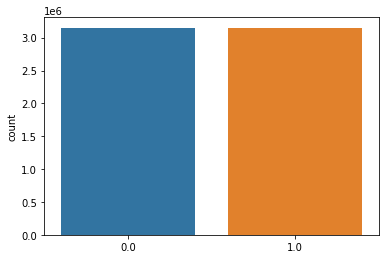

In [11]:
# Balanceando os dados 
ros = RandomOverSampler()
Xtrain, Ytrain = ros.fit_resample(Xtrain, Ytrain)
sns.countplot(Ytrain)


In [12]:
# Normalização dos dados
scaleX = StandardScaler()
Xtrain = scaleX.fit_transform(Xtrain)
Xtest = scaleX.fit_transform(Xtest)

### Regressão linear multipla

O primeiro modelo testado nesse arquivo foi uma regressão linear múltipla. Os resultados obtidos ficaram na faixa de 50-60% de acurácia. Além disso foi testado também o backward elimination que testa quais variáveis fazem ou não sentido para a regressão linear e em geral aumentava a acurácia em alguns %.

Acurácia: 56.72265935505108%


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

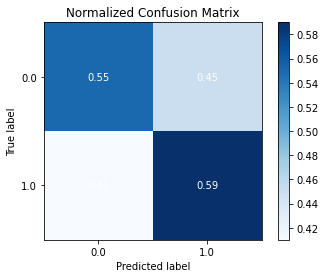

In [13]:
# Regressão linear multipla com Backward Elimination
from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm

# print(Xtest.shape)
# Xotimo = Xtrain[:, [0, 1, 2, 4, 5, 6, 7, 8, 9, 10]]
# Xtesto = Xtest[:, [0, 1, 2, 4, 5, 6, 7, 8, 9, 10]]

regressor = LinearRegression()
regressor.fit(Xtrain, Ytrain)
Ypred = regressor.predict(Xtest)

Ypred = [round(value) for value in Ypred]

# Imprimindo a Acurácia
accuracy = accuracy_score(Ytest, Ypred)
print(f'Acurácia: {accuracy*100}%')

# Imprimir matriz de confusão

skplt.metrics.plot_confusion_matrix(Ytest, Ypred, normalize=True)

### XGBoost classificador

Aqui foi treinado o classificador do XGBoost. Algumas configurações foram testadas, mas a acurácia ficava entre 50-60%. Esse é um modelo que, diferentemente da regressão linear, é um classficador em árvore de descisão. 

/home/jps12/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:23:11] WARNING: ../src/learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:23:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acurácia: 54.15154794045656%


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

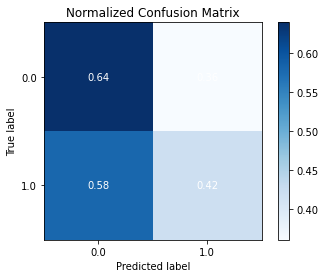

In [14]:
# XGBoost Classifier
params = {"objective":"reg:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

model = xgb.XGBClassifier(params=params)
model.fit(Xtrain, Ytrain)

Ypred = model.predict(Xtest)

accuracy = accuracy_score(Ytest, Ypred)
print(f'Acurácia: {accuracy*100}%')

# Imprimir matriz de confusão

skplt.metrics.plot_confusion_matrix(Ytest, Ypred, normalize=True)